In [9]:
import time
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

# Function to draw image with caption
def plotImg(img, caption):
    plt.figure()
    plt.axis('off')
    ht = img.shape[0]+25
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)    
    plt.text(0,ht,caption)

# Load and return image in RGB space
def loadImage(fname):
    return cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)

imgNo = 1
figNo = 1
def plotSubImage(img, caption):
    global imgNo
    plt.subplot(1, 2, imgNo)
    imgNo += 1
    plt.axis('off')

    scaledShape=(64, int(64.0*img.shape[1] / img.shape[0]))
    if len(img.shape) == 2:
        plt.imshow(img, shape=scaledShape, cmap='gray')
    else:
        plt.imshow(img, shape=scaledShape)
        
    plt.text(0, 0, caption, fontsize=10)


## Histogram of Oriented Gradients (HOG) Features



In [21]:
def get_feature_image(image, colorspace, channel):
    # apply color conversion if other than 'RGB'
    if colorspace != 'RGB':
        if colorspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif colorspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif colorspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif colorspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif colorspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
        
    if channel == 'ALL':
        return feature_image
    else:
        return feature_image[:,:,channel]

# Define a function to return HOG features and visualization for a single channel
def get_hog_features_single_channel(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)

def get_hog_features_multi_channel(feature_image, orient, pix_per_cell, cell_per_block):
    if len(feature_image.shape) > 1: # all channels
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features_single_channel(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features_single_channel(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    return hog_features
    
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features
    
# Define a function to compute color histogram features
def bin_spatial(feature_image, size=(32, 32)):           
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features


In [22]:
### Feature genration parameters
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"

## Data Set
* Vehicle data set: 8798 samples
* Non-vehicle data set: 8971 samples
* Udacity data set: 15000 samples

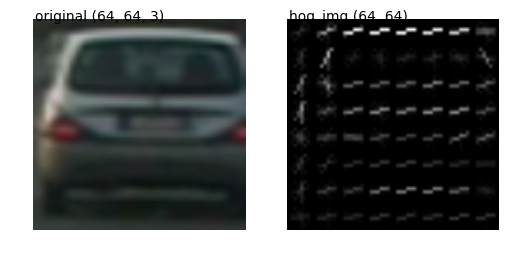

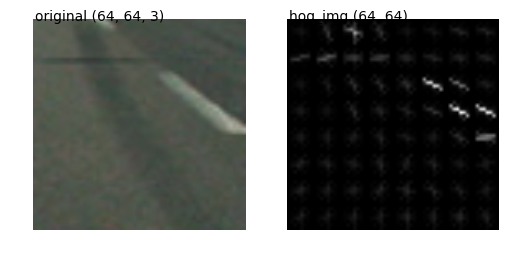

In [23]:
def hog_sample(fname):
    global imgNo
    image = loadImage(fname)
    feature_image = get_feature_image(image, colorspace, hog_channel)
    if len(feature_image.shape) > 1:
        feature_image = feature_image[:,:,0]
    fvec, hog_img = get_hog_features_single_channel(feature_image, orient, pix_per_cell, cell_per_block, vis=True)
    plt.figure()
    imgNo = 1
    plotSubImage(image, 'original {0}'.format(image.shape))
    plotSubImage(hog_img, 'hog_img {0}'.format(hog_img.shape))

hog_sample('vehicles/GTI_MiddleClose/image0313.png')
hog_sample('non-vehicles/GTI/image2319.png')


In [24]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_filelist(imgs):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = loadImage(file)
        features.append(extract_image_features(img))
    return features
        
def extract_image_features(image):

    feature_image = get_feature_image(image, colorspace, hog_channel)

    hog_features = get_hog_features_multi_channel(feature_image, orient, pix_per_cell, cell_per_block)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)

    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    # Append the new feature vector to the features list
    return np.concatenate((spatial_features, hist_features, hog_features))



In [25]:
# Divide up into cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

t=time.time()
car_features = extract_features_filelist(cars)
notcar_features = extract_features_filelist(notcars)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

#save model
with open('model.p', 'wb') as f:
    pickle.dump((svc,X_scaler), f)

54.93 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
4.51 Seconds to train SVC...
Test Accuracy of SVC =  0.9938
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
0.00079 Seconds to predict 10 labels with SVC


In [26]:
# load model
with open('model.p', 'rb') as f:
    (svc2, X_scaler2) = pickle.load(f)


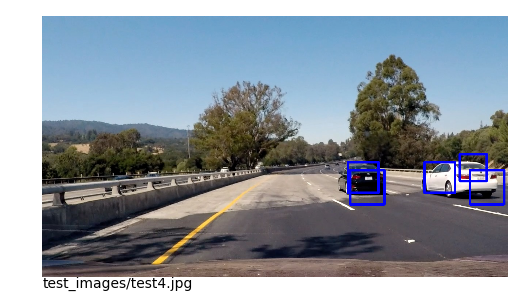

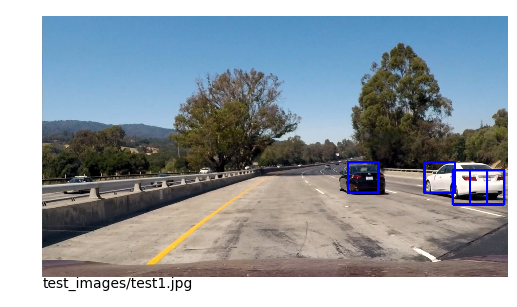

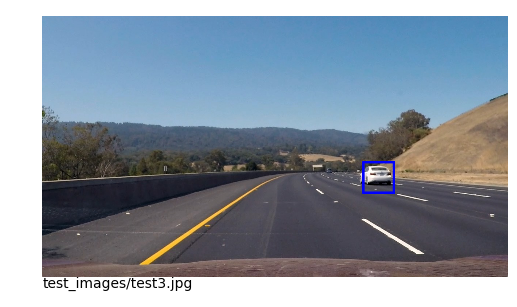

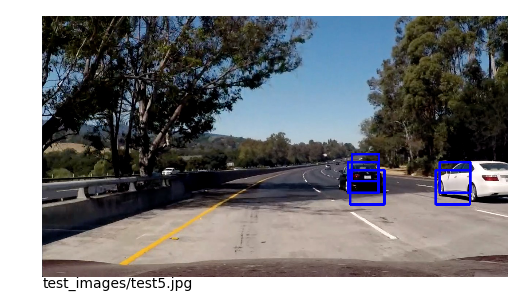

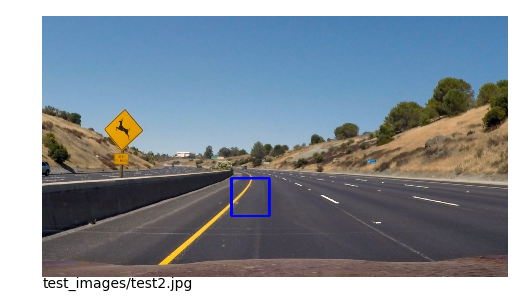

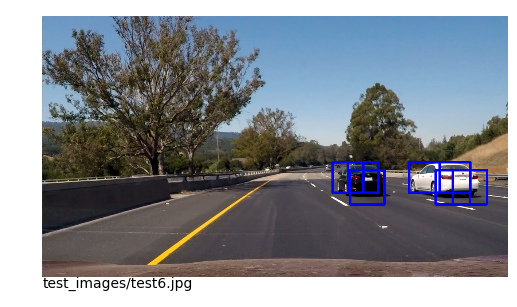

In [32]:
def make_windows(shape):
    windows=[]
    scan_y0 = shape[0] // 2
    scan_y1 = shape[0]
    scan_x0 = 0
    scan_x1 = shape[1]
    dim = 64
    for y1 in range(scan_y0 + dim, scan_y1, dim // 2):
        for x0 in range(scan_x0, scan_x1, dim // 2):
            window = ((x0,y1-dim),(x0+dim,y1))
            if(window[0][0] >= 0 and window[0][1] >= 0 and window[1][0] <= shape[1] and window[1][1] <= shape[0]):
                windows.append(window)
        dim += 10
    return windows
        
def image_features(img, windows):
    hog_cache = hog
    features = []
    for window in windows:
        test = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        hog_vals = hog_cache[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        test64 = cv2.resize(test, (64,64))
        features.append(extract_image_features(test64))
    return features

def imgPipeline(img):
    windows = make_windows(img.shape)
    features = image_features(img, windows)
    scaled_features = X_scaler2.transform(features)
    pred = svc2.predict(scaled_features)
    for idx in np.argwhere(pred == 1):
        cv2.rectangle(img, windows[idx][0], windows[idx][1], (0,0,255), 6)
    return img

for fname in glob.glob('test_images/*.jpg'):
    img = loadImage(fname)
    img = imgPipeline(img)
    plotImg(img, fname)